In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
k_id, temporal_freq = itemgetter("k_id", "w")(params["stimulus"])
angular_freq = temporal_freq * 2 * np.pi

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
tau_rc_mix_in = itemgetter("tau")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])
tau_rc_mix_ex = itemgetter("tau")(params["relay"]["Krc_mix"]["Krc_ex"])


delayed_in, synced, delayed_ex = itemgetter("delayed_in", "synced", "delayed_ex")(params["relay"]["Krc_mix"])

## Run and plot

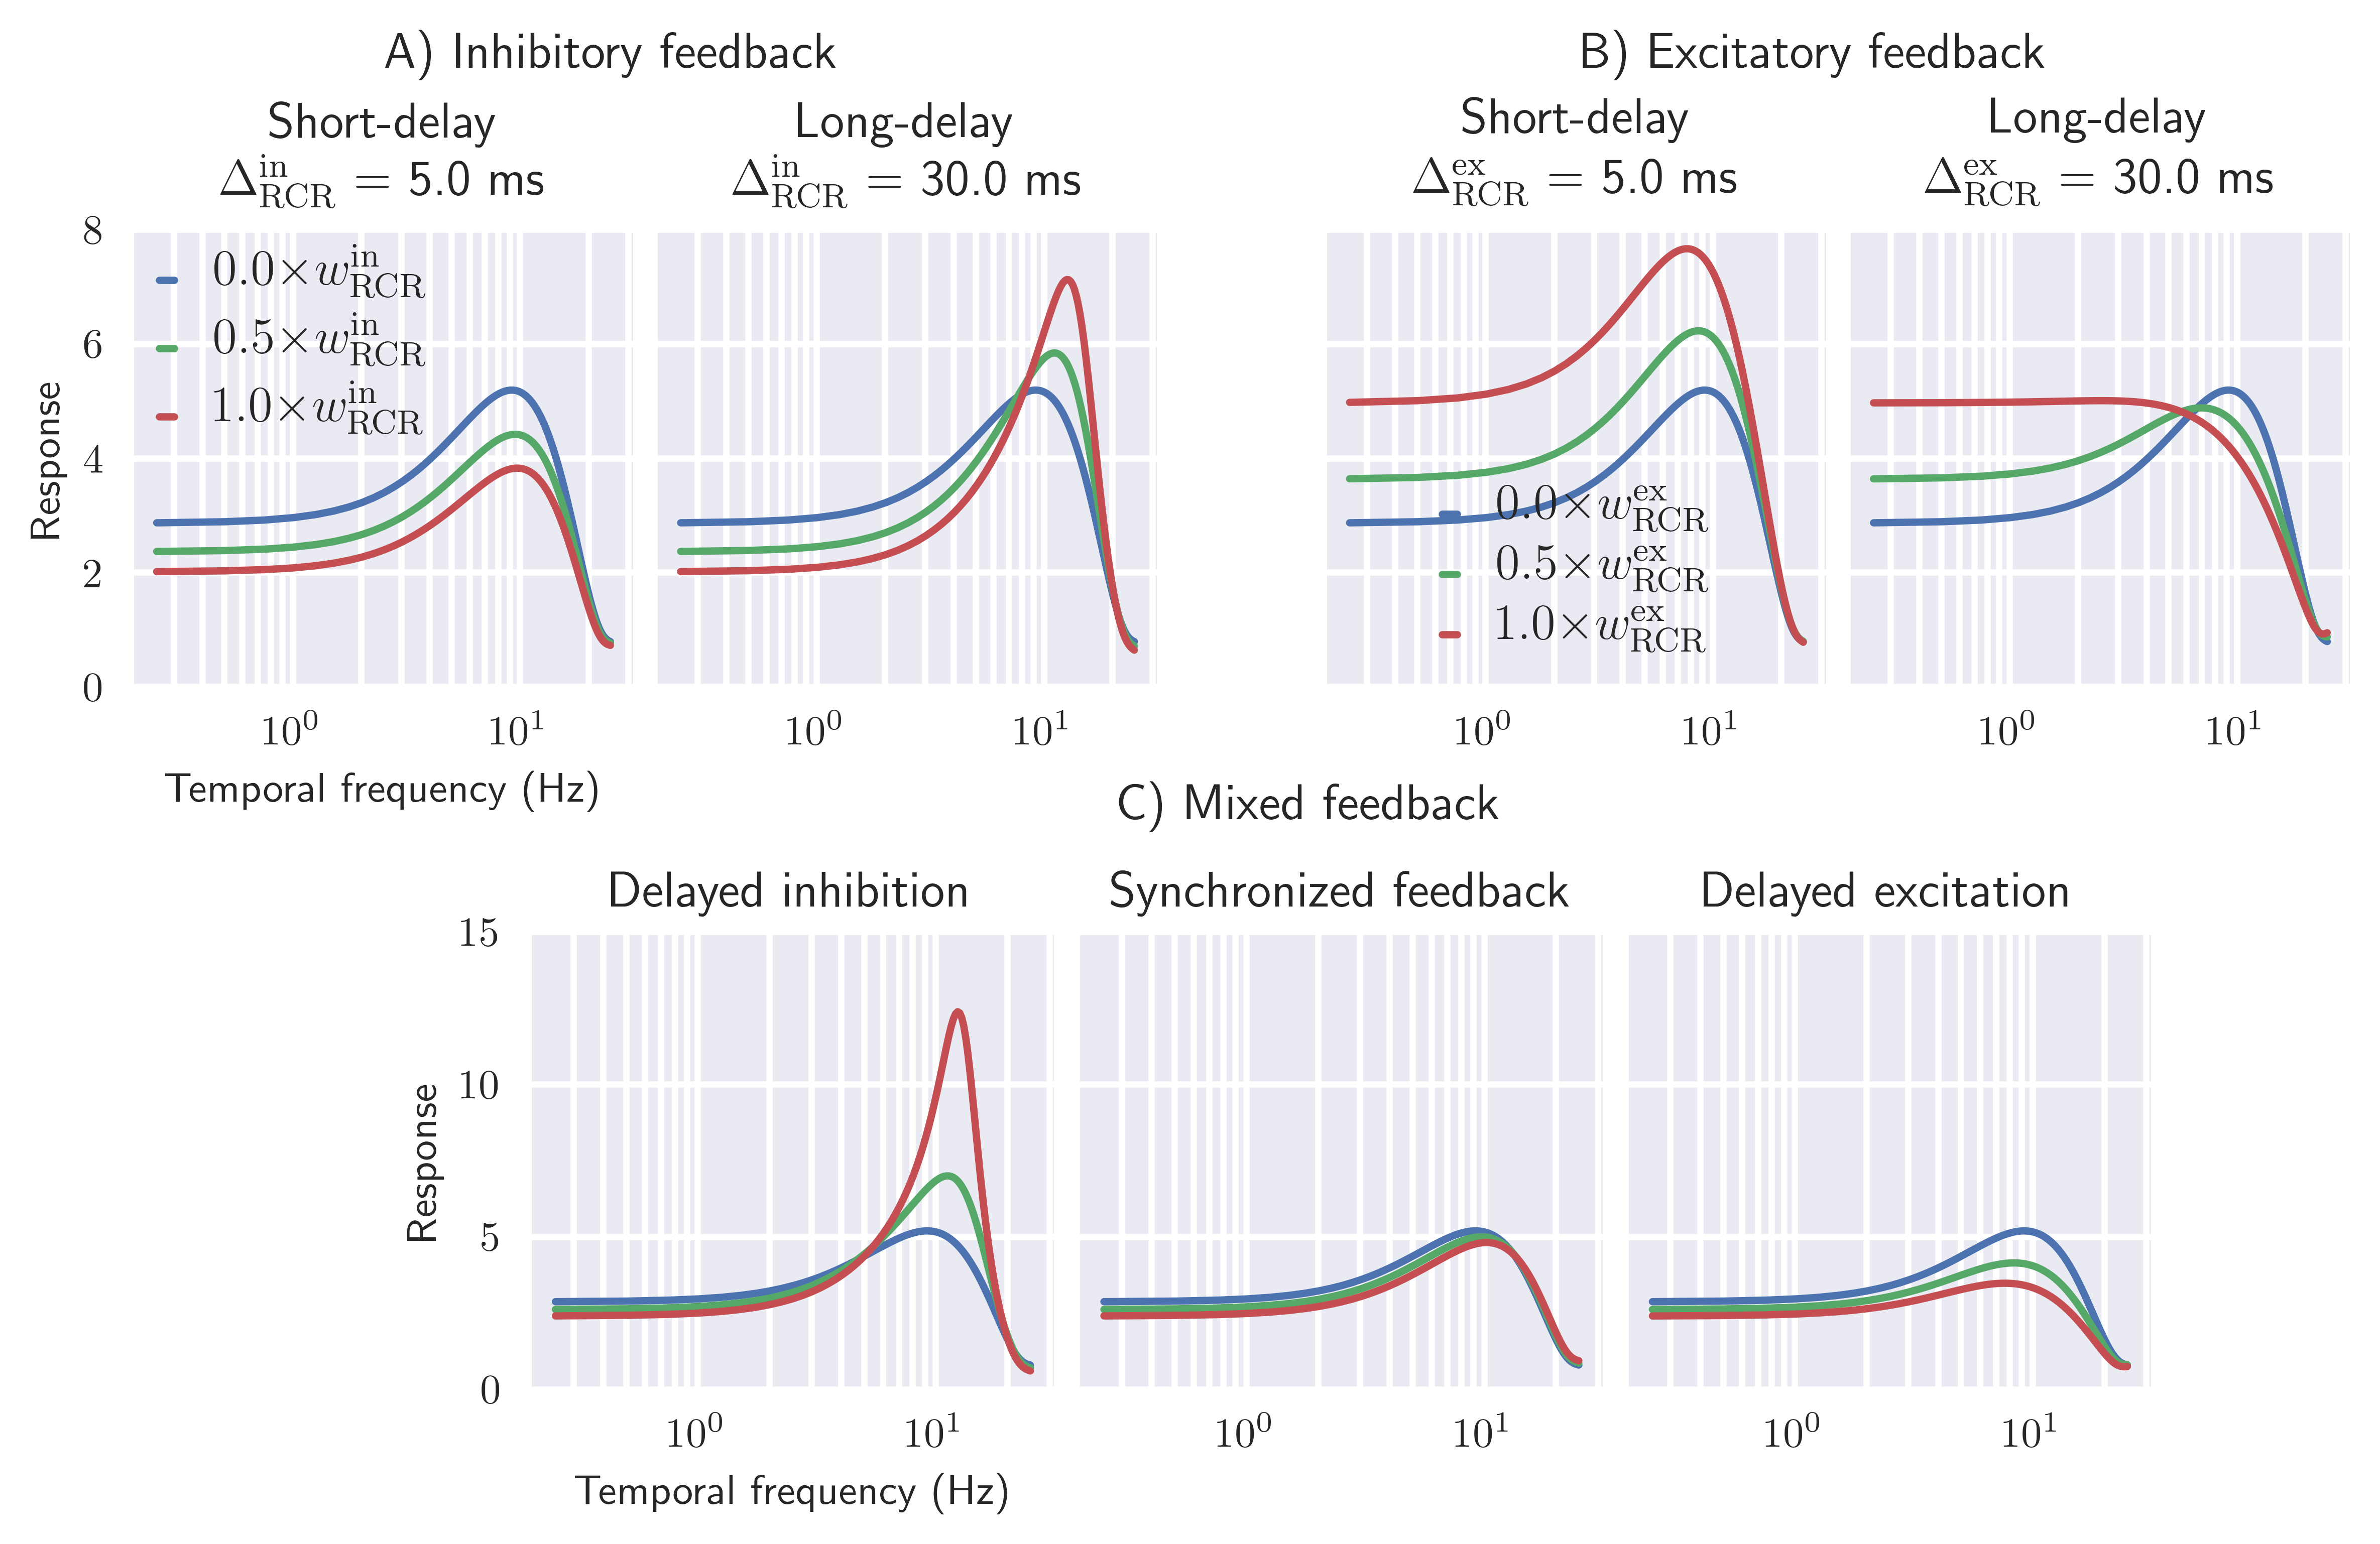

In [4]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 12)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 0:6], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 6:12], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, 2:11], wspace=0.05)


ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1], sharey=ax1, sharex=ax1)
ax3 = plt.subplot(gs2[0, 0], sharey=ax1, sharex=ax1)
ax4 = plt.subplot(gs2[0, 1], sharey=ax1, sharex=ax1)
ax5 = plt.subplot(gs3[0, 0])
ax6 = plt.subplot(gs3[0, 1], sharey=ax5)
ax7 = plt.subplot(gs3[0, 2], sharey=ax5)

gs.update(hspace=100, wspace=20)

for ax in [ax2, ax3, ax4, ax6, ax7]:
    plt.setp(ax.get_yticklabels(), visible=False)

    
plt.figtext(0.26, 0.999, "A) Inhibitory feedback", ha='center', va='center', fontsize=12)
plt.figtext(0.76, 0.999, "B) Excitatory feedback", ha='center', va='center', fontsize=12)
plt.figtext(0.55, 0.50, "C) Mixed feedback", ha='center', va='center', fontsize=12)



title_delay = ["Short-delay", "Long-delay"]
label_in = r"$w^\mathrm{in}_{\mathrm{RCR}}$"
label_ex = r"$w^\mathrm{ex}_{\mathrm{RCR}}$"
delay_label_in = r"$\Delta_\mathrm{RCR}^\mathrm{in}$"
delay_label_ex = r"$\Delta_\mathrm{RCR}^\mathrm{ex}$"

titles_mix = ["Delayed inhibition", "Synchronized feedback", "Delayed excitation"]
label_mix = r"$w^\mathrm{ex/in}_{\mathrm{RCR}}$"

# inhibitory FB
for ax, delay, delay_title in zip([ax1, ax2], delay_rc_in, title_delay):
    for w in w_rc_in:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau_rc_in, delay_rc_in=delay)
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        title = "{}\n{} = {}".format(delay_title, delay_label_in, round(delay, 1))

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label_in)
        ax.set_title(title, fontsize=12, linespacing=1.4)
        ax.grid(which="both", lw=1.5)

# excitatory FB            
for ax, delay, delay_title in zip([ax3, ax4], delay_rc_in,  title_delay):
    for w in w_rc_ex:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex, delay_rc_ex=delay)
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        title = "{}\n{} = {}".format(delay_title, delay_label_ex, round(delay, 1))

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label_ex)
        ax.set_title(title, fontsize=12, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

ax1.set_xlabel("Temporal frequency (Hz)")
ax1.set_ylabel("Response")
ax1.set_ylim([0, 8])
ax1.legend(fontsize=12, handlelength=0.3, labelspacing=0.3, borderpad=0.0)
ax3.legend(fontsize=12, handlelength=0.3, labelspacing=0.3, borderpad=0.0)


# Mixed FB
for ax, title, params in zip([ax5, ax6, ax7], titles_mix, [delayed_in, synced, delayed_ex]):
    for w in w_rc_mix:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_ex=w, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex,
                                                tau_rc_ex=tau_rc_mix_ex, delay_rc_ex=params["delay_ex"],
                                                w_rc_in=w, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                                                tau_rc_in=tau_rc_mix_in, delay_rc_in=params["delay_in"])
                                                
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_angular_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, 0/pq.deg)
        tuning = np.absolute(tuning)

        ax.semilogx(temporal_freq, tuning, label=r"${} \times$".format(round(w, 1))+label_mix)
        ax.set_title(title, fontsize=12, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

ax5.set_xlabel("Temporal frequency (Hz)")
ax5.set_ylabel("Response")
ax5.set_ylim([0, 15])


gs.tight_layout(fig)